In [1]:
import stacn
import scanpy as sc
import mnmstpy as mnmst
import pandas as pd
import numpy as np
import os
import sys
from sklearn.metrics.cluster import adjusted_rand_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
section_id = "151675"
input_dir = os.path.join('../data', section_id)
adata = sc.read_visium(path=input_dir, count_file=section_id + '_filtered_feature_bc_matrix.h5')

sc.pp.calculate_qc_metrics(adata, inplace=True)
adata = adata[:, adata.var['total_counts'] > 100]
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.filter_genes(adata, min_cells=1)
hvg_filter = adata.var['highly_variable']
sc.pp.normalize_total(adata, inplace=True)
adata = adata[:, hvg_filter]
display(adata)

View of AnnData object with n_obs × n_vars = 3592 × 3001
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'spatial', 'hvg'
    obsm: 'spatial'

In [3]:
Ann_df = pd.read_csv(os.path.join('../data', section_id, section_id+'_truth.txt'), sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']
adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth']

In [6]:
enhanced_adata, cell_spatial = mnmst.data_enhance(adata, k_nei=6)


Median distance to closest cell = 138.00362314084367
num_nbrs: 3001


In [7]:
sc.pp.pca(enhanced_adata)
low_dim_x = enhanced_adata.obsm['X_pca']
expression = low_dim_x
spatial_network = cell_spatial.A

# Running stACN

In [8]:
Z_all =  stacn.st_acn(expression, spatial_network, lamb=0.001, dim=200)

 58%|████████████████████████████████████████████████████████████████████████████████████▋                                                             | 29/50 [30:43<22:14, 63.56s/it]


# Tutorials of using Spectral Clustering

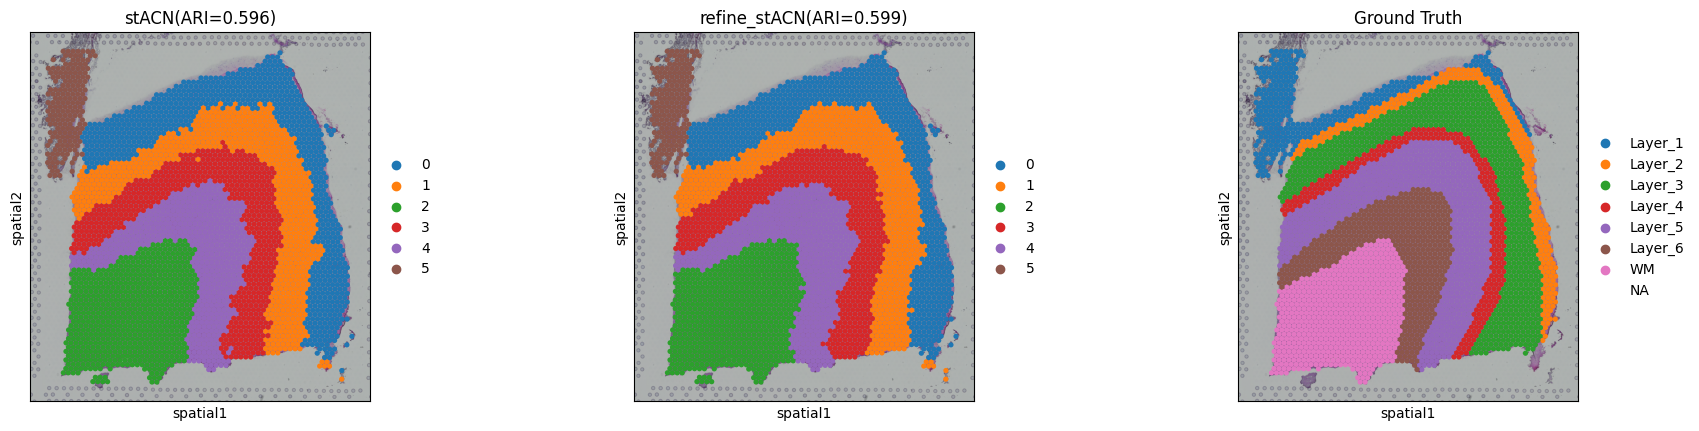

In [30]:
from stacn.utils import refine
weights_adj = cell_spatial.A
refined_pred = refine(sample_id=adata.obs.index.tolist(), pred=adata.obs['stACN'].tolist(),dis=weights_adj, shape="hexagon")
adata.obs["refined_pred"] = refined_pred
adata.obs["refined_pred"] = adata.obs["refined_pred"].astype('category')
stACN_ari = adjusted_rand_score(pd.Categorical(adata.obs['Ground Truth']).codes, adata.obs['stACN'])
refine_ari = adjusted_rand_score(pd.Categorical(adata.obs['Ground Truth']).codes, adata.obs['refined_pred'])
sc.pl.spatial(adata, color=['stACN', 'refined_pred', 'Ground Truth'], title=['stACN(ARI=%.3f)'% stACN_ari, 'refine_stACN(ARI=%.3f)'%refine_ari, 'Ground Truth'], size=1.5)

In [ ]:
from sklearn.cluster import SpectralClustering
n_clusters = 7
spectral = SpectralClustering(n_clusters=n_clusters)
labels = spectral.fit_predict(Z_all)
adjusted_rand_score(pd.Categorical(adata.obs['Ground Truth']).codes, labels)
adata.obs['spe_pred'] = labels
adata.obs["spe_pred"] = adata.obs["spe_pred"].astype('int')
adata.obs['spe_pred'] = adata.obs['spe_pred'].astype('category')
sc.pl.spatial(adata, color=['spe_pred'])

In [ ]:
from stacn.utils import refine

weights_adj = cell_spatial.A
refined_pred = refine(sample_id=adata.obs.index.tolist(), pred=adata.obs['spe_pred'].tolist(), dis=weights_adj, shape="hexagon")
adata.obs["refined_pred"] = refined_pred
adata.obs["refined_pred"] = adata.obs["refined_pred"].astype('category')
stACN_ari = adjusted_rand_score(pd.Categorical(adata.obs['Ground Truth']).codes, adata.obs['spe_pred'])
refine_ari = adjusted_rand_score(pd.Categorical(adata.obs['Ground Truth']).codes, adata.obs['refined_pred'])
stACN_ari, refine_ari

In [ ]:
sc.pl.spatial(adata, color=['spe_pred', 'refined_pred', 'Ground Truth'], title=['stACN(ARI=%.3f)'% stACN_ari, 'refine_stACN(ARI=%.3f)'%refine_ari, 'Ground Truth'], size=2)